# Aprendendo a usar callbacks.

## Iremos usar o dataset Cats Vs Dogs. https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset

In [ ]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
# Setando os diretórios
train_dir = 'F:/dogs-vs-cats/train/train'
test_dir = 'F:/dogs-vs-cats/test1/test1'


train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [4]:
print(f'Numero de imagens em {train_dir} é: {len(train_files)}')
print(f'Numero de imagens em {test_dir} é: {len(test_files)}')

Numero de imagens em F:/dogs-vs-cats/train/train é: 25000
Numero de imagens em F:/dogs-vs-cats/test1/test1 é: 12500


In [5]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

F:/dogs-vs-cats/train/train\cat.0.jpg


### Criando transformações

In [6]:
transformations = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

## **Criando uma classe Dataset que armazene as informações do nosso conjunto de dados (caminhos, rótulos e transformações).** 

Este objeto pode então ser utilizado por funções torch, como `torch.utils.data.random_split`.

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [7]:
class Dataset():

    def __init__(self, filelist, filepath, transform = None):

        self.filelist = filelist

        self.filepath = filepath

        self.transform = transform

    
    def __len__(self):
        return int(len(self.filelist))
    
    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])

        img = Image.open(imgpath)

        #print(imgpath)
        if "dog." in imgpath:
            #print("TEM DOG") cuidado com prints, são funções que bloqueiam a CPU e fazem a GPU trabalhar mais devagar.
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [8]:
train = Dataset(train_files, train_dir, transformations)

val = Dataset(test_files, test_dir, transformations)

In [9]:
# Usando um objeto de dataset

train.__getitem__(20000)

(tensor([[[0.3294, 0.1608, 0.0902,  ..., 0.3882, 0.3843, 0.3804],
          [0.1176, 0.1569, 0.0941,  ..., 0.3843, 0.3843, 0.3804],
          [0.1608, 0.1451, 0.1059,  ..., 0.3843, 0.3804, 0.3804],
          ...,
          [0.8000, 0.7922, 0.7961,  ..., 0.7843, 0.7255, 0.6039],
          [0.7961, 0.7882, 0.7922,  ..., 0.8588, 0.8118, 0.5529],
          [0.7882, 0.7804, 0.7843,  ..., 0.8510, 0.8588, 0.5333]],
 
         [[0.3961, 0.2431, 0.1569,  ..., 0.5451, 0.5412, 0.5373],
          [0.1843, 0.2353, 0.1882,  ..., 0.5412, 0.5412, 0.5373],
          [0.2235, 0.2196, 0.2039,  ..., 0.5373, 0.5373, 0.5373],
          ...,
          [0.7961, 0.7882, 0.7922,  ..., 0.6824, 0.6157, 0.4941],
          [0.7922, 0.7843, 0.7882,  ..., 0.7529, 0.7020, 0.4392],
          [0.7843, 0.7765, 0.7804,  ..., 0.7490, 0.7490, 0.4235]],
 
         [[0.4627, 0.3137, 0.2353,  ..., 0.6824, 0.6784, 0.6745],
          [0.2471, 0.3059, 0.2627,  ..., 0.6784, 0.6784, 0.6745],
          [0.2863, 0.2824, 0.2745,  ...,

In [10]:
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


### Splitando o dataset

In [11]:
train, val = torch.utils.data.random_split(train,[20000,5000]) 


In [12]:
print(len(train))
print(len(val))

20000
5000


In [13]:
# vamos criar os labels agora
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

## **Dataloaders - vamos criar nosso iterável sobre um conjunto de dados**

In [14]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

# Vendo algumas imagens

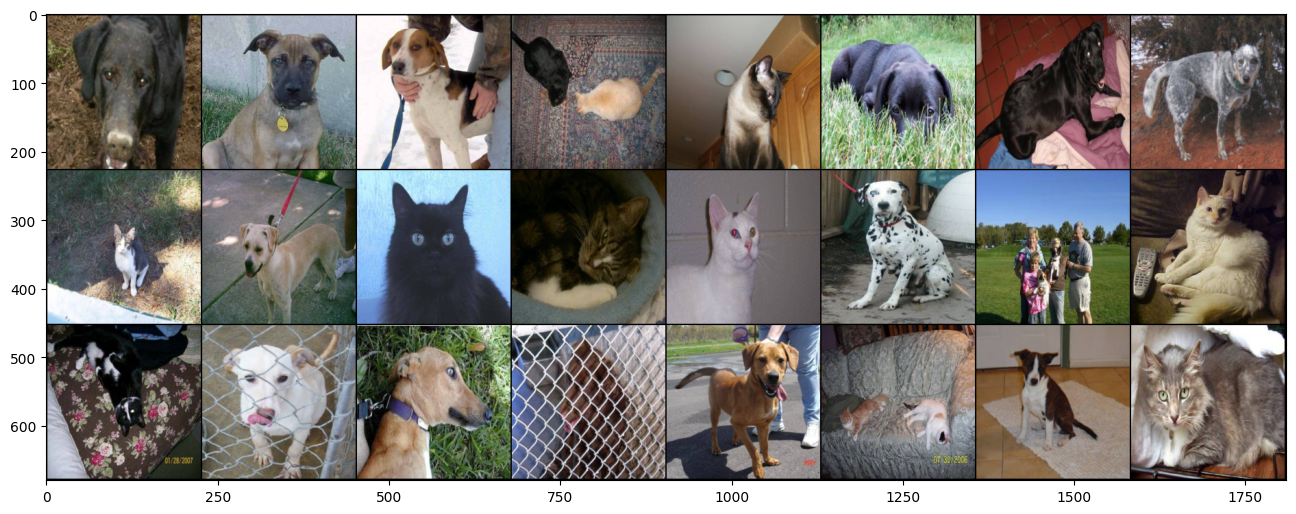

In [15]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

Agora vamos construir nosso modelo

Usaremos o método `nn.Sequential` para construir nosso modelo. Alternativamente, podemos usar o módulo funcional, mas este é mais simples e mais semelhante aos estilos com os quais você trabalhará no Keras.

In [16]:
class CNN(nn.Module):

    def __init__(self):

        super().__init__()
        # Bloco 1: 3x224x224 -> 16x111x111
        self.conv1 = nn.Sequential(

            nn.Conv2d(3, 16, 3), #(224 - 3) + 1 = 222 # Saída 16x222x222
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 222 / 2 = 111 # Saída 16x111x111
        )
        # Bloco 2: 16x111x111 -> 32x54x54
        self.conv2 = nn.Sequential(

            nn.Conv2d(16,32,3), #(111 - 3) + 1 = 109 # Saída 32x109x109
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 109/2 = 54 Saída 32x54x54

        )
        # Bloco 3: 32x54x54 -> 64x26x26
        self.conv3 = nn.Sequential(

            nn.Conv2d(32, 64, 3), # (54 - 3) + 1 = 52 # Saída 64x52x52
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 52 / 2 = 26 # Saída 64x26x26

        )
        # Bloco 4: 64x26x26 -> 128x12x12
        # 
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 26 - 3 + 1 = 24 # Saída 128x24x24
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   #24 / 2 = 12  # Saída 128x12x12
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
            
        )

        self.fc2 = nn.Sequential(
            nn.Linear(128, 2)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.softmax(x, dim = 1)
        

### **Usando TorchSummary para exibir uma saída de resumo no estilo Keras**

`summary(seu_modelo, tamanho_da_entrada=(canais, H, W))`

In [17]:
model = CNN()
model.to(device)
summary(model,input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       448
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       4,640
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       18,496
|    └─ReLU: 2-8                         --
|    └─MaxPool2d: 2-9                    --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-10                      73,856
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-5                        --
|    └─Flatten: 2-13                     --
|    └─Linear: 2-14                      9,437,696
|    └─ReLU: 2-15                        --
|    └─Linear: 2-16                      65,664
|   

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       448
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       4,640
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       18,496
|    └─ReLU: 2-8                         --
|    └─MaxPool2d: 2-9                    --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-10                      73,856
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-5                        --
|    └─Flatten: 2-13                     --
|    └─Linear: 2-14                      9,437,696
|    └─ReLU: 2-15                        --
|    └─Linear: 2-16                      65,664
|   

### **Definindo uma função de perda e um otimizador**

Precisamos definir que tipo de perda usaremos e que método usaremos para atualizar os gradientes.
1. Usamos a perda de entropia cruzada.
2. Usamos o algoritmo de otimização de descida Adam — também especificamos uma taxa de aprendizagem (LR) de 0,0005.
3. Definimos nossas épocas como 50.

In [18]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 50

## **Treinar nosso modelo**

**Usamos o TQDM para realizar um treinamento no estilo Keras**

In [19]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

## Implementando um EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
    
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("Stopping early observou estagnação no melhoramento da loss de validação")



patience = 5  # Épocas para esperar após não melhoramento
delta = 0.01  # Mudança mínima a ser monitorada no erro
best_val_loss = float("inf")  # podemos armazenar a melhor loss
no_improvement_count = 0  # contador de épocas sem redução na loss

early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

In [21]:
"""
Antes de tudo, instale o pacote:

conda install -n base -c conda-forge widgetsnbextension
conda install -n pyenv -c conda-forge ipywidgets
"""

train_loss = []

train_accuracy = []

val_loss = []

val_accuracy = []


for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0
    # Defina nossa unidade para tqdm e número de iterações, ou seja, len(train_dataset), sem necessidade de len, pois train_dataset é iterável.

    with tqdm(train_dataset, unit = 'batch') as tepoch:
        # nosso progresso vai ser mostrado em barras

        tepoch.set_description(f'Época {epoch+1}/{epochs}')

        for data, label in tepoch:
            
            data = data.to(device)
            label = label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimiser.step()

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # quantas imagens foram propagadas

            total += label.size(0)

            # quantas imagens estão corretas

            correct += (pred == label).sum().item()
        
        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f"Época {epoch+1} Acurácia de treino = {correct/total}")
        print(f"Época {epoch+1} Erro de treino = {train_running_loss/len(train_dataset)}")


    #Validação
    if epoch % 1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        #Não calculando gradientes, ocupando menos memória com o contexto no_grad()
        with torch.no_grad():

            for val_data, val_label in val_dataset:

                val_data, val_label = val_data.to(device), val_label.to(device)

                val_output = model(val_data)

                loss_val = criterion(val_output, val_label)


                #calculando o erro atual pela multiplicação do erro pelo tamanho do batch

                val_running_loss += loss_val.item() * val_data.size(0)

                _, pred = torch.max(val_output.data, 1)

                total += val_label.size(0)

                correct += (pred == val_label).sum().item()
            

            val_accuracy.append(correct/total)

            #calculando o erro por época, pela divisão do erro atual pelo nnumero de itens na base de validação

            val_loss.append(val_running_loss/len(val_dataset))

            print(f"Época {epoch+1} acurácia de validação = {correct/total}")
            print(f"Época {epoch+1} erro de validação = {val_running_loss/len(val_dataset)}")

        early_stopping.check_early_stop(val_running_loss/len(val_dataset))
    
        if early_stopping.stop_training:
            print(f"Early stopping na época {epoch}")
            break



C:\Users\Gabriel\AppData\Local\Temp\ipykernel_24484\2946321970.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit = 'batch') as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 1 Acurácia de treino = 0.60405
Época 1 Erro de treino = 21.12661497344971
Época 1 acurácia de validação = 0.6714
Época 1 erro de validação = 19.603070180127574


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 2 Acurácia de treino = 0.70585
Época 2 Erro de treino = 18.79557942352295
Época 2 acurácia de validação = 0.6902
Época 2 erro de validação = 19.07090566416455


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 3 Acurácia de treino = 0.7521
Época 3 Erro de treino = 17.469962094116212
Época 3 acurácia de validação = 0.7472
Época 3 erro de validação = 17.517989146481654


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 4 Acurácia de treino = 0.7903
Época 4 Erro de treino = 16.42102972869873
Época 4 acurácia de validação = 0.7602
Época 4 erro de validação = 17.18065061386983


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 5 Acurácia de treino = 0.8184
Época 5 Erro de treino = 15.577417376708985
Época 5 acurácia de validação = 0.7824
Época 5 erro de validação = 16.50723919898841


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 6 Acurácia de treino = 0.84345
Época 6 Erro de treino = 14.782705155944825
Época 6 acurácia de validação = 0.784
Época 6 erro de validação = 16.534691020941278


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 7 Acurácia de treino = 0.8729
Época 7 Erro de treino = 13.993982720947265
Época 7 acurácia de validação = 0.7758
Época 7 erro de validação = 16.804225523760365


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 8 Acurácia de treino = 0.8914
Época 8 Erro de treino = 13.414601148986817
Época 8 acurácia de validação = 0.7896
Época 8 erro de validação = 16.41253835532316


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 9 Acurácia de treino = 0.9104
Época 9 Erro de treino = 12.842284712219238
Época 9 acurácia de validação = 0.7828
Época 9 erro de validação = 16.57509071204313


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 10 Acurácia de treino = 0.9217
Época 10 Erro de treino = 12.482435668945312
Época 10 acurácia de validação = 0.7952
Época 10 erro de validação = 16.234941997345846


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 11 Acurácia de treino = 0.92885
Época 11 Erro de treino = 12.24665294342041
Época 11 acurácia de validação = 0.8038
Época 11 erro de validação = 16.053342246705558


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 12 Acurácia de treino = 0.9364
Época 12 Erro de treino = 12.042832577514648
Época 12 acurácia de validação = 0.7932
Época 12 erro de validação = 16.367923135210756


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 13 Acurácia de treino = 0.9417
Época 13 Erro de treino = 11.87040838623047
Época 13 acurácia de validação = 0.7914
Época 13 erro de validação = 16.409398125994738


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 14 Acurácia de treino = 0.94295
Época 14 Erro de treino = 11.820383717346191
Época 14 acurácia de validação = 0.7914
Época 14 erro de validação = 16.380685063684062


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 15 Acurácia de treino = 0.94805
Época 15 Erro de treino = 11.685543771362305
Época 15 acurácia de validação = 0.7962
Época 15 erro de validação = 16.290632387635053


  0%|          | 0/625 [00:00<?, ?batch/s]

Época 16 Acurácia de treino = 0.94935
Época 16 Erro de treino = 11.601001156616212
Época 16 acurácia de validação = 0.8
Época 16 erro de validação = 16.194215106356676
Stopping early as no improvement has been observed.
Early stopping na época 15


In [22]:
train_loss

[21.12661497344971,
 18.79557942352295,
 17.469962094116212,
 16.42102972869873,
 15.577417376708985,
 14.782705155944825,
 13.993982720947265,
 13.414601148986817,
 12.842284712219238,
 12.482435668945312,
 12.24665294342041,
 12.042832577514648,
 11.87040838623047,
 11.820383717346191,
 11.685543771362305,
 11.601001156616212]

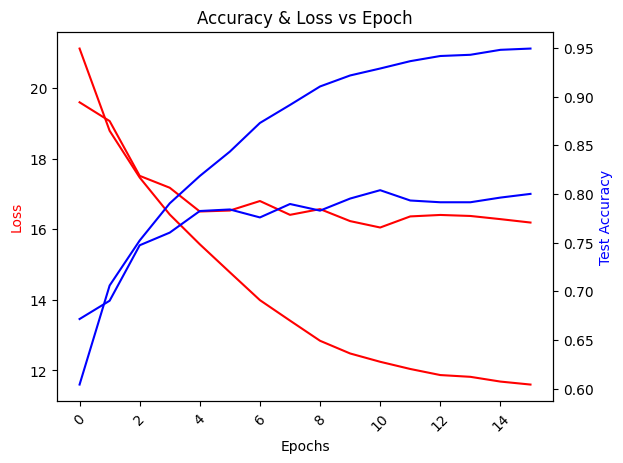

In [ ]:
epoch_log = [*range(len(train_loss))] #pegando o tamanho do vetor do erro de treino (basicamente o numero de epocas executadas - GAMBIARRA)

fig, ax1 = plt.subplots()

# Setando o titulo e o rotulo do eixo x
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

#  Usando a função twinx para criar um plot de um segundo eixo Y
ax2 = ax1.twinx()


ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')


ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [27]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

## Verificando os resultados com o GroundTruth

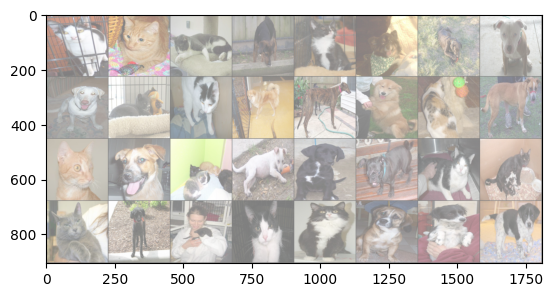

GroundTruth:  0|0|0|1|0|1|1|1|1|0|0|1|1|1|0|1|0|1|0|1|1|1|0|0|0|1|0|0|0|1|1|1


In [28]:
# função para mostrar imagem
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Carregando um mini-batch
dataiter = iter(val_dataset)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ','|'.join('%1s' % labels[j].numpy() for j in range(32)))

In [29]:
model = CNN()
model.to(device)

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

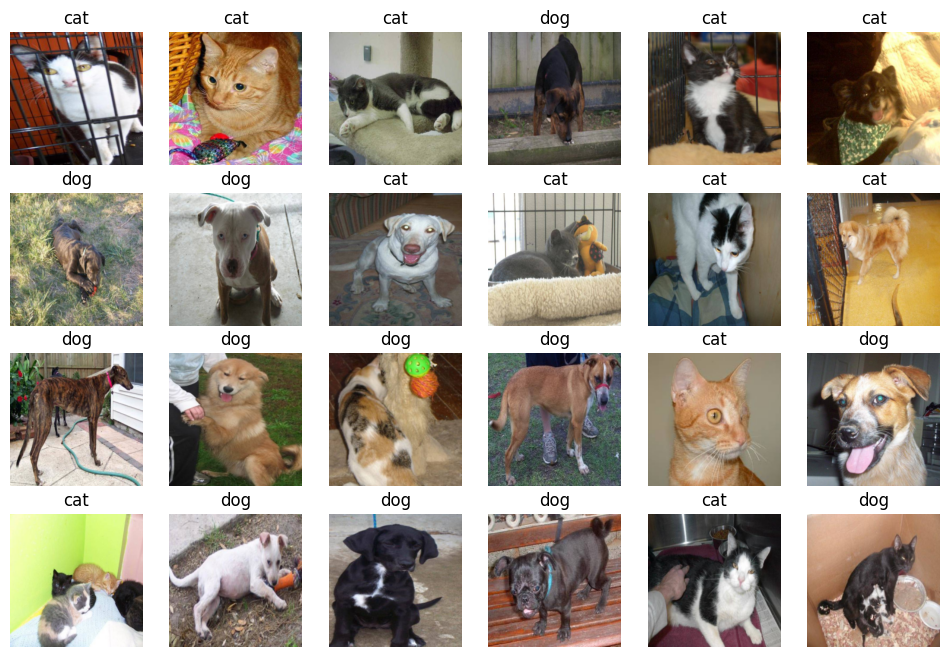

In [30]:
samples, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))